## Tutorial 2: Spectral graph theory and signals on networks

In this tutorial we will study the properties of the graph Laplacian and its eigenvalues for some toy problem.
We will use the [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html) library.

## Setup

In [2]:
!pip install pygsp==0.5.1
!pip install celluloid==0.2.0

In [3]:
from IPython.display import HTML, clear_output

from celluloid import Camera
import matplotlib.pyplot as plt
import numpy as np
import pygsp


## Three graphs

We consider three networks in this tutorial:
1. A *circular* graph with 40 nodes and edges;
2. A random *sensor* network with 50 nodes.
3. The *road network* of Minnesota, consisting of 2642 conjunctions and 3304 roads;

These are all available in PyGSP in the `graphs` module. Let's instanciate them.

In [4]:
g_ring = pygsp.graphs.Ring(40)
g_sens = pygsp.graphs.Sensor(50)
g_road = pygsp.graphs.Minnesota()

# And keep a list to iterate over them
graphs = [g_ring, g_sens, g_road]


We can now visualize the graphs.

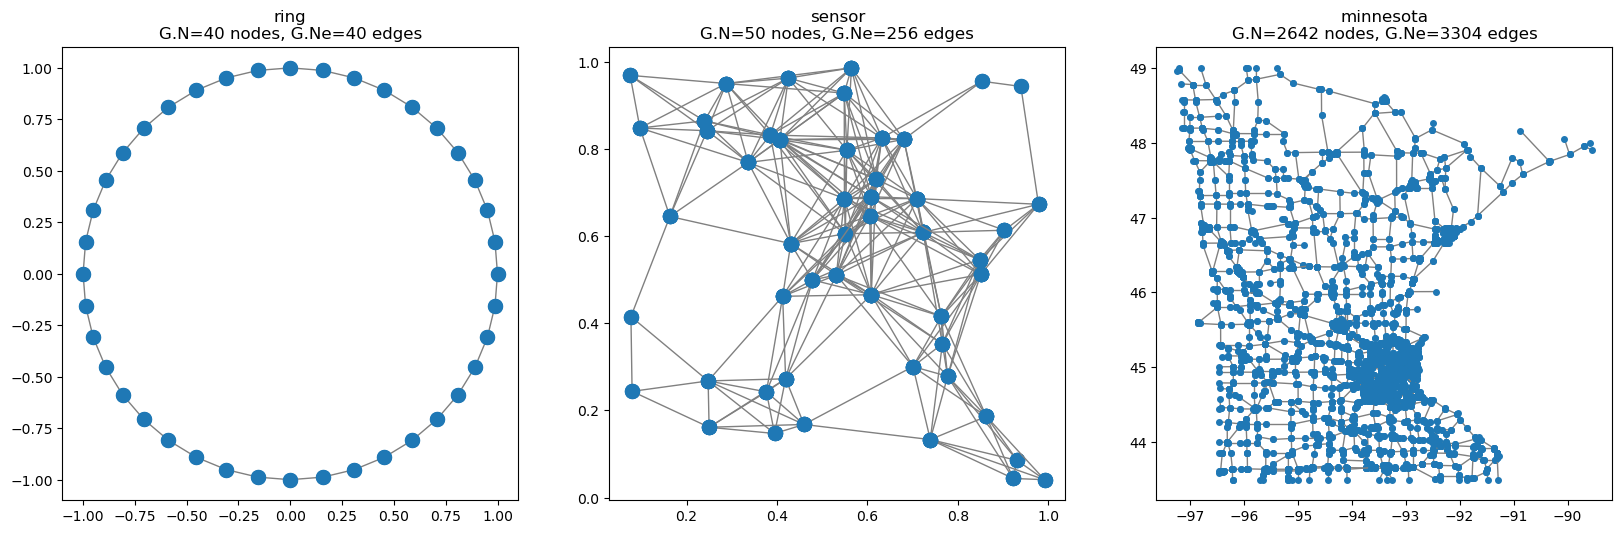

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=100)

for ax, g in zip(axes, graphs):
    g.plot(ax=ax)

plt.show()


The focus of this tutorial is on the **combinatorial Laplacian**. Let's start by inspecting the adjacency matrices of our networks.

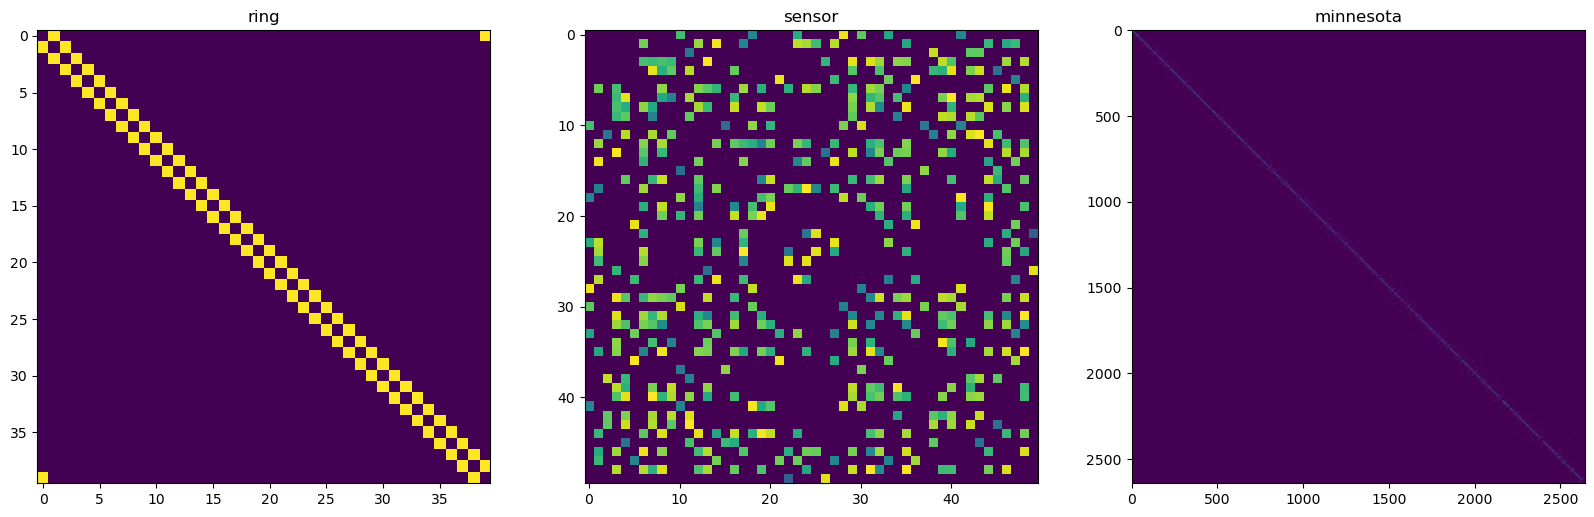

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=100)

for ax, g in zip(axes, graphs):
    # NOTE: Weights are sparse arrays
    ax.imshow(g.W.todense())
    ax.set(title=g.gtype)

plt.show()


## Laplacian eigenvectors

When working with *NumPy arrays*, or *SciPy sparse arrays*, we can obtain the eigendecomposition with methods provided in the respective`linalg` modules. Still, this is a computationally intensive task ($\mathcal O (N)$), so one should use the best-suited method for computing eigenvalues and, if needed, vectors.

For instance, Hermitian (symmetric) matrices have an easier decomposition, and sparse arrays allow to extract only a few eigenvalues.

Since spectral decomposition is so useful in network analysis, PyGSP graphs keep it ready once they compute it.

In [8]:
for g in graphs:
    g.compute_fourier_basis()


Let's visualize the ring Fourier basis.

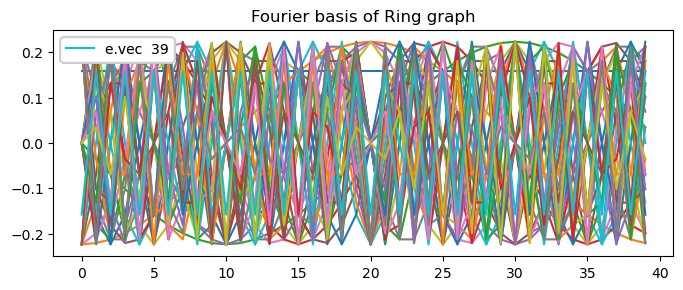

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
camera = Camera(fig)

ax.set(title="Fourier basis of Ring graph", ylim=(-0.25, 0.25))

for i, fb in enumerate(g_ring.U.T):
    line = ax.plot(fb)
    ax.legend(line, [f"e.vec {i:> 2d}"], loc="upper left")
    camera.snap()

plt.show()
HTML(camera.animate(interval=500).to_html5_video())


Does this remind you of anything? :thinking:

For the other graphs, it is hard to visualize already the second eigenvector on the line. What would be a more meaningful visualization?

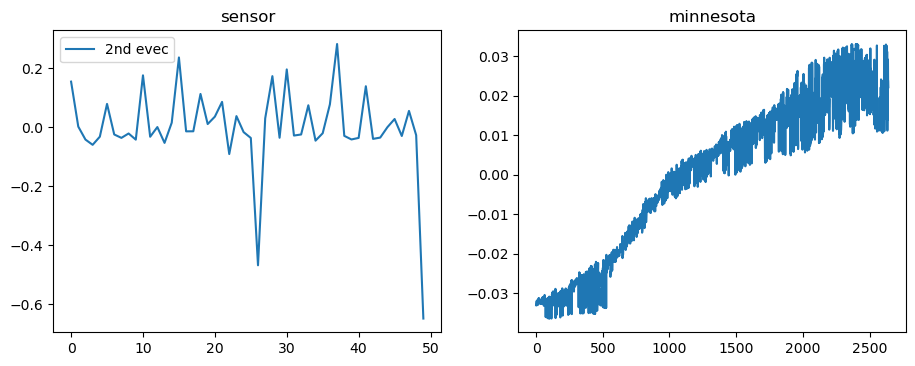

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), dpi=100)

axes[0].plot(g_sens.U[:, 1], c="tab:blue", label="2nd evec")
# axes[0].plot(g_sens.U[:, -1], c='tab:red', label='last evec')
axes[0].set(title=g_sens.gtype)
axes[0].legend()

axes[1].plot(g_road.U[:, 1], c="tab:blue", label="2nd evec")
# axes[1].plot(g_road.U[:, -1], c='tab:red', label='last evec')
axes[1].set(title=g_road.gtype)

plt.show()


It is much more meaningful to observe the eigenvalues on the original domain, i.e. on the **nodes**.

In [11]:
def animate_eigvals(graph, max_evecs=25, interval=1000, **im_kwargs):
    fig, ax = plt.subplots(
        1, 1, figsize=im_kwargs.get("figsize", (5, 5)), dpi=im_kwargs.get("dpi", 100)
    )

    camera = Camera(fig)

    # NOTE: Weights are sparse arrays
    for i, fb in enumerate(graph.U.T[:max_evecs]):
        graph.plot_signal(fb, colorbar=False, ax=ax)

        x, y = ax.get_xlim()[0], ax.get_ylim()[1]
        ax.text(0.9 * x, 0.9 * y, f"e.vec {i:> 2d}")
        camera.snap()

    return camera.animate(interval=interval).to_html5_video()


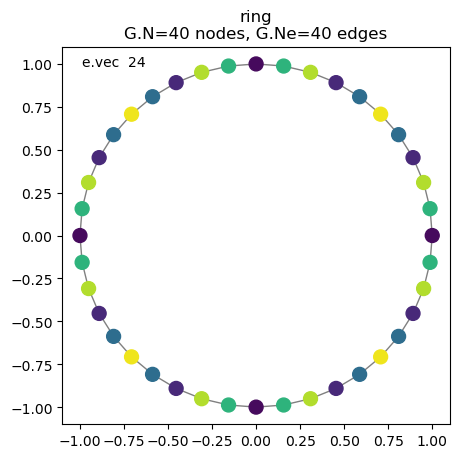

In [13]:
HTML(animate_eigvals(g_ring))


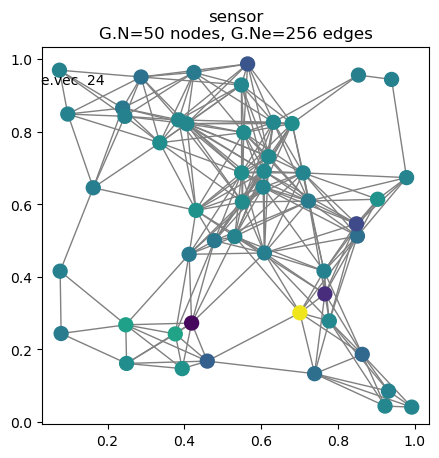

In [14]:
HTML(animate_eigvals(g_sens))


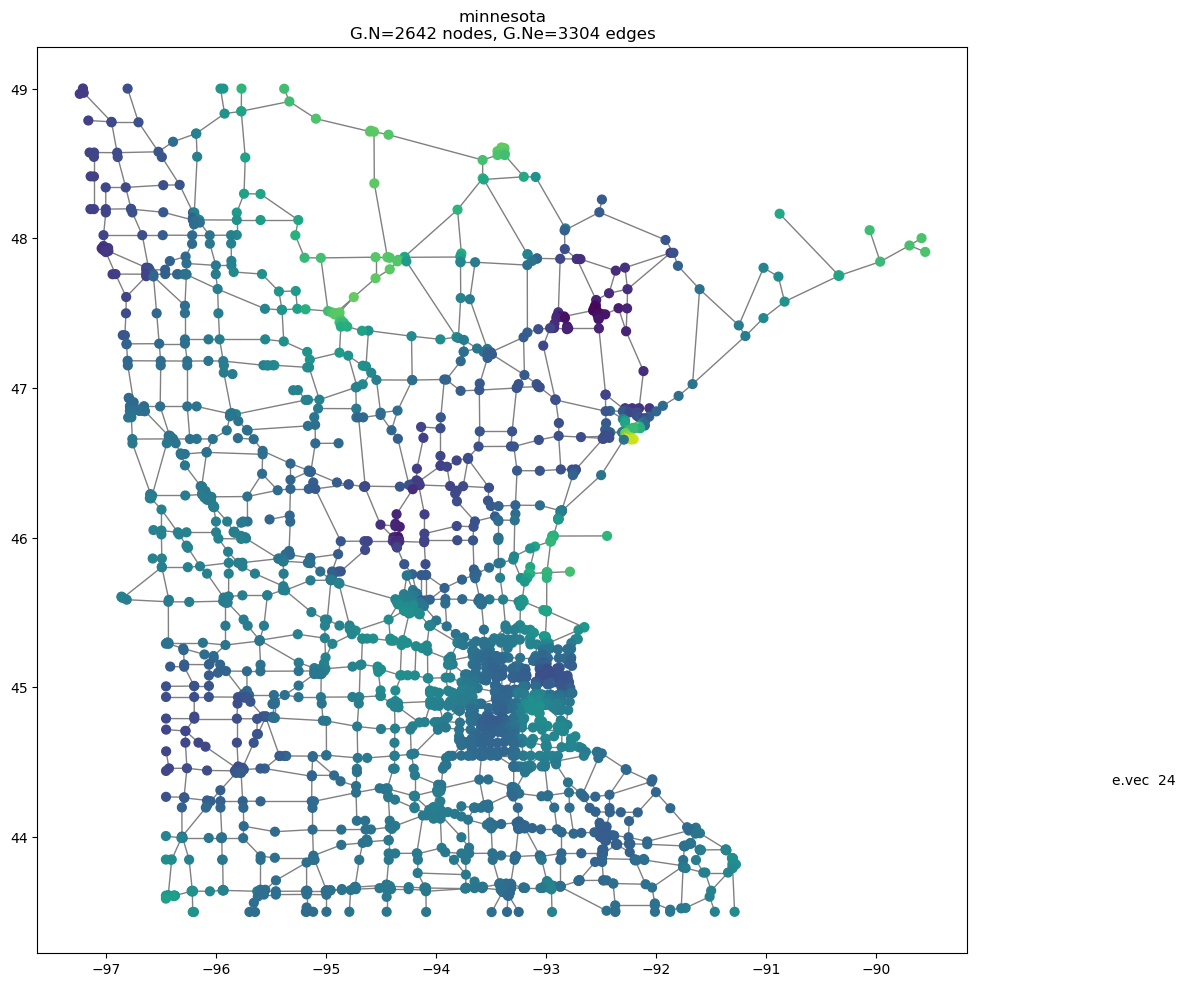

In [15]:
HTML(animate_eigvals(g_road, figsize=(12, 12)))


Let's focus on the road network. What can you see from the first eigenvalues?

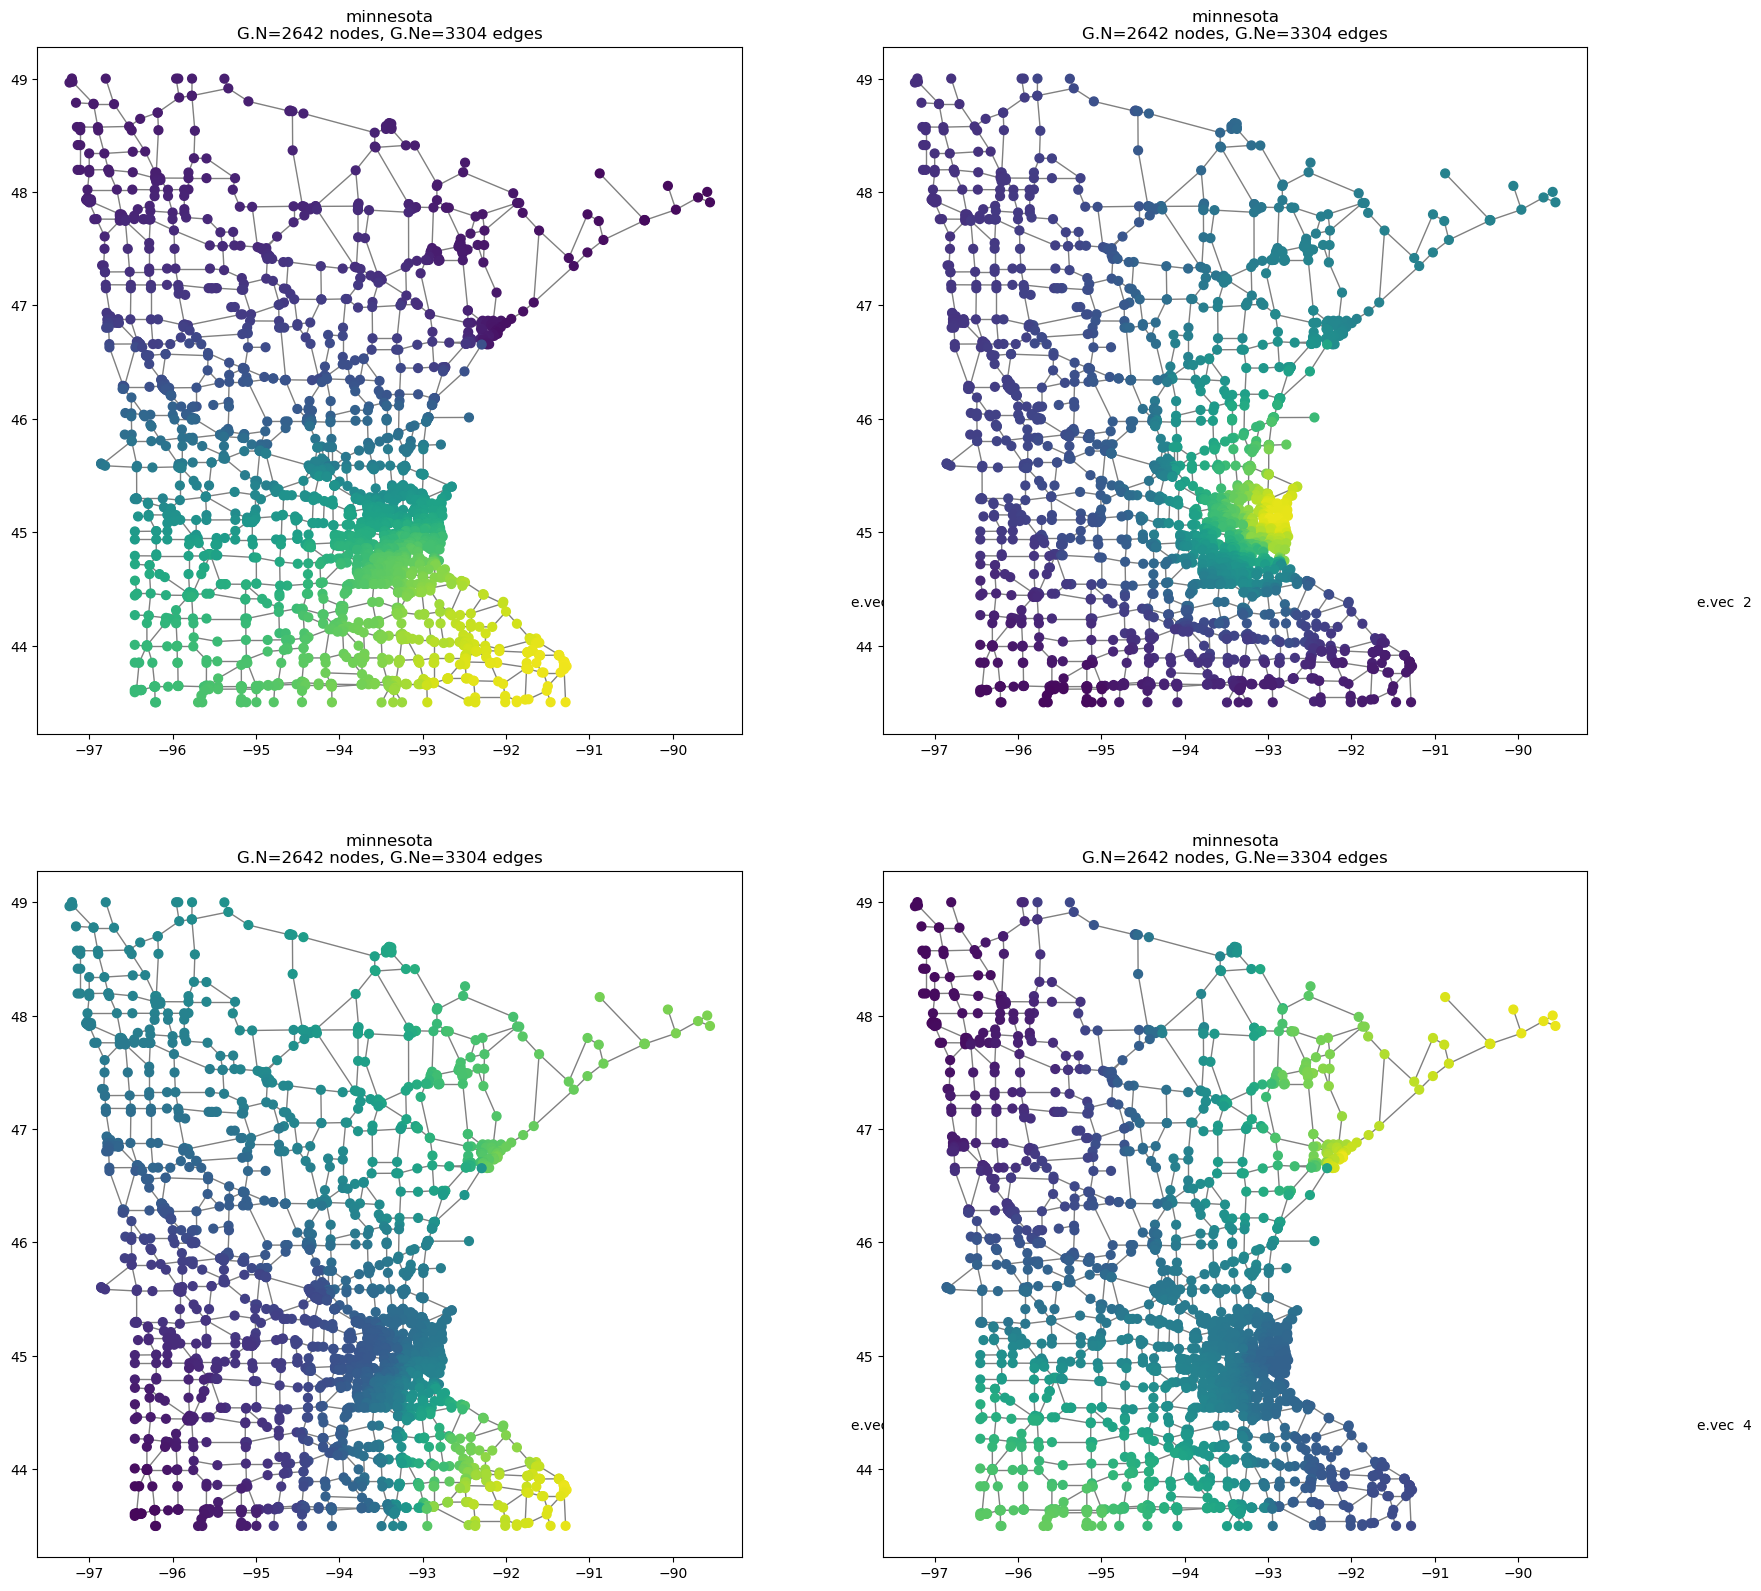

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), dpi=100)

for i, ax in enumerate(axes.ravel()):
    g_road.plot_signal(g_road.U[:, i + 1], colorbar=False, ax=ax)

    x, y = ax.get_xlim()[0], ax.get_ylim()[1]
    ax.text(0.9 * x, 0.9 * y, f"e.vec {i+1:> 2d}")
plt.show()


And in particular, let's look at the sign of the second eigenvector, i.e. the **Fiedler vector**

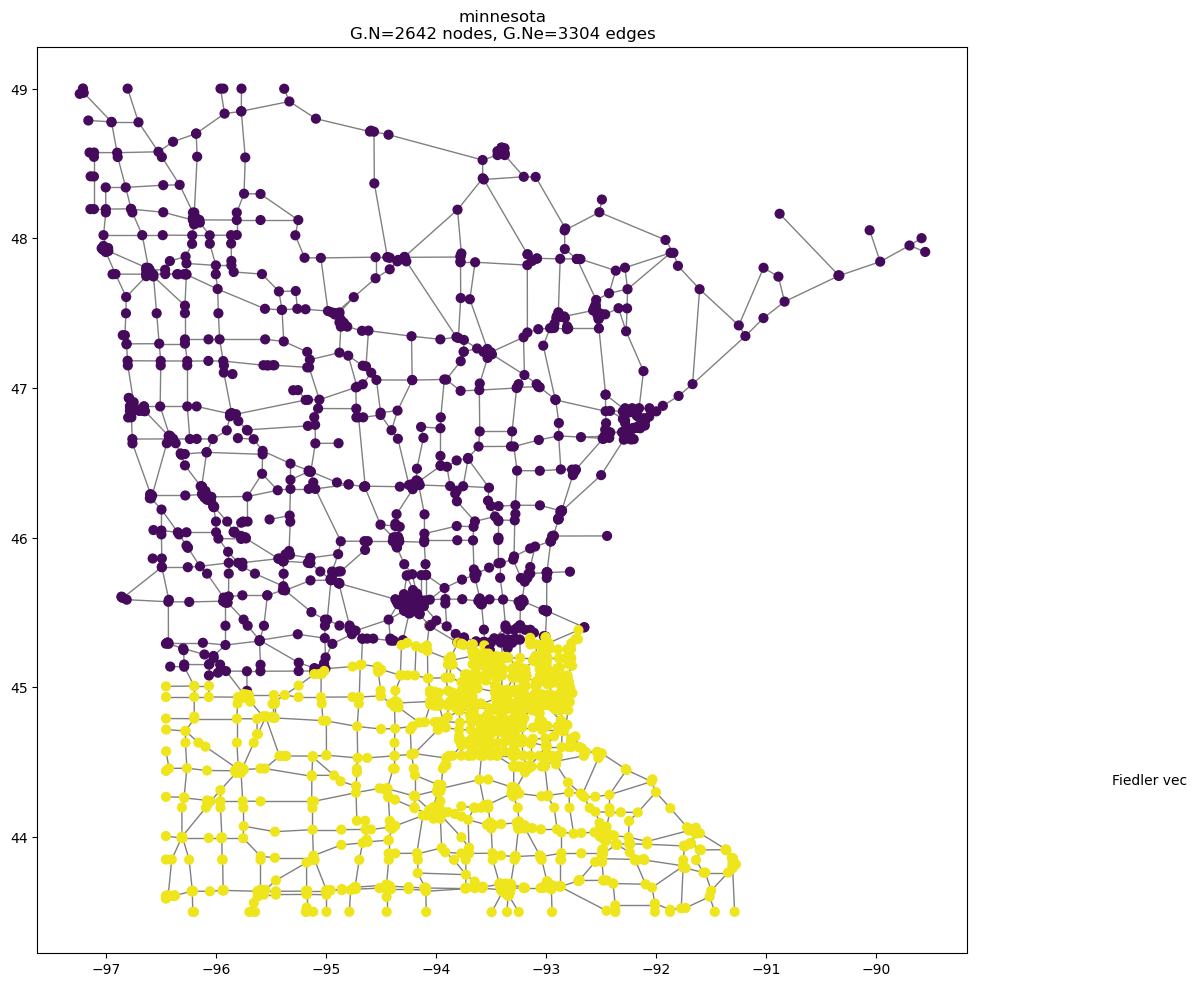

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=100)

g_road.plot_signal(np.sign(g_road.U[:, 1]), colorbar=False, ax=ax)

x, y = ax.get_xlim()[0], ax.get_ylim()[1]
ax.text(0.9 * x, 0.9 * y, f"Fiedler vec")

plt.show()


## Graph filters

As on regular domains (e.g. time or images), we can define filters on graphs, too. Filters act on the frequencies of input signals to produce new signals on the same graph.

An easy example is the **heat filter**, which intuitively spreads "energy" on neighboring nodes.

Let's create some signals (vectors) on our graphs.

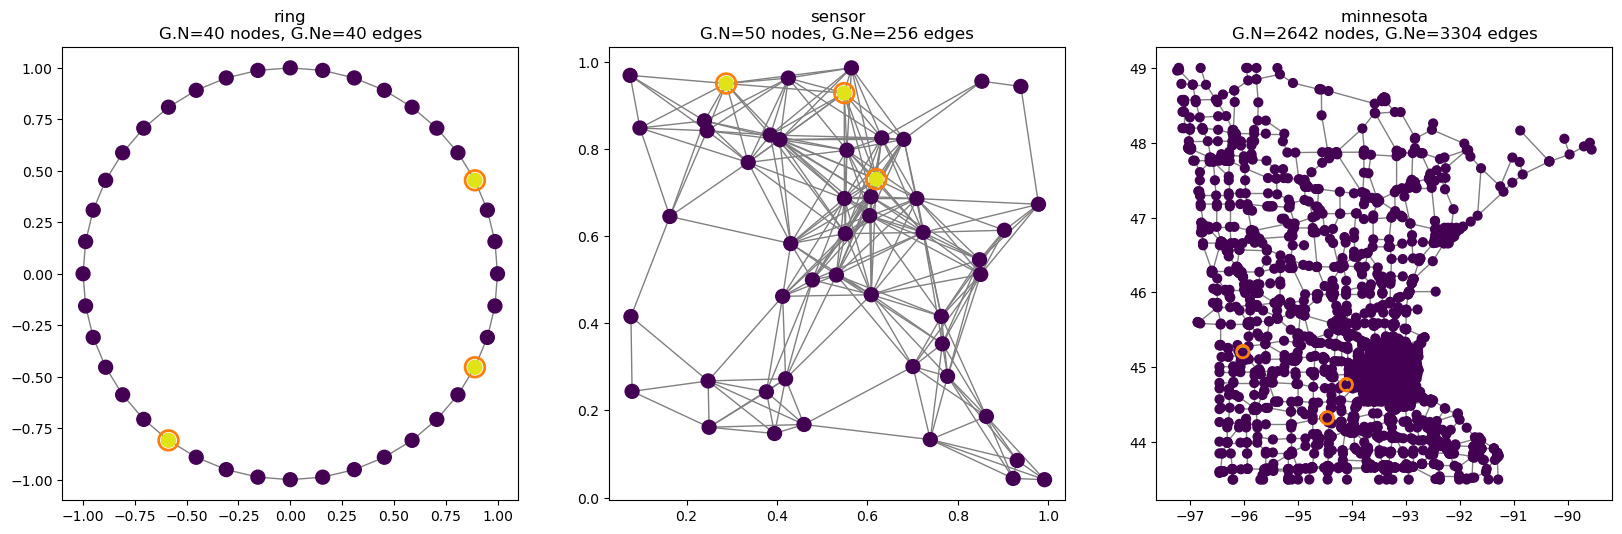

In [18]:
signals = []

fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=100)

for g, ax in zip(graphs, axes):
    x = np.zeros(g.N, dtype=int)
    x[np.random.choice(g.N, size=3, replace=False)] = g.N / 10

    g.plot_signal(x, highlight=np.nonzero(x)[0], colorbar=False, ax=ax)

    signals.append(x)

plt.show()


Now, we define heat filters for each network. They are defined on the spectral domain as
$$
    \hat{g}(x) = \exp \left( \frac{-\tau x}{\lambda_{\text{max}}} \right)
$$

The filter is bound to the graph, as it has to mirror it's structure!

In [19]:
filters = [pygsp.filters.Heat(g, tau=10) for g in graphs]


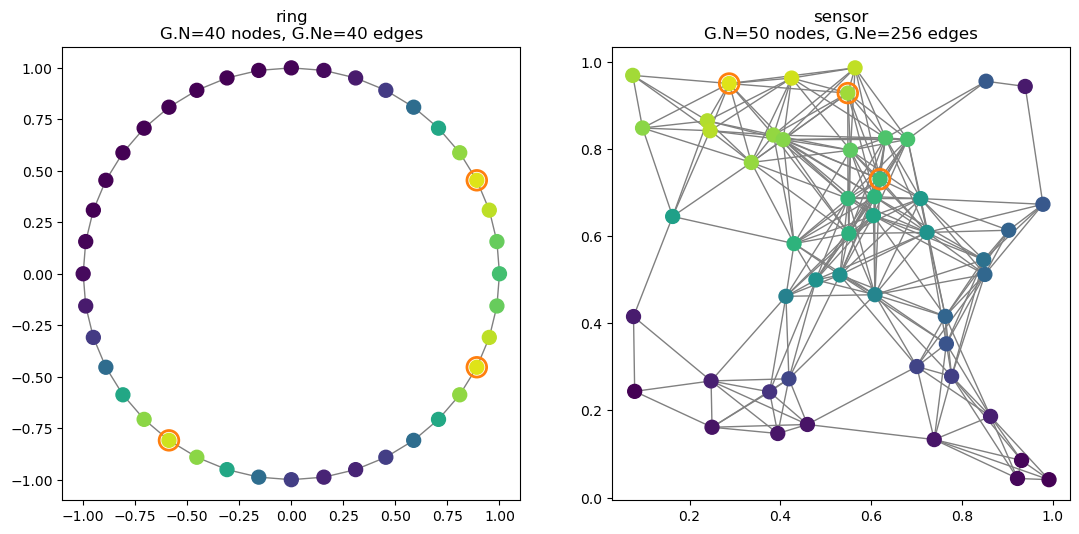

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), dpi=100)

for x, g, filter, ax in zip(signals, graphs, filters, axes):
    g.plot_signal(filter.filter(x), colorbar=False, highlight=np.nonzero(x)[0], ax=ax)

plt.show()


For the road network, we can see the initial signal as traffic jams on some junctions. The diffusion process then might model how cars spread out from those nodes.

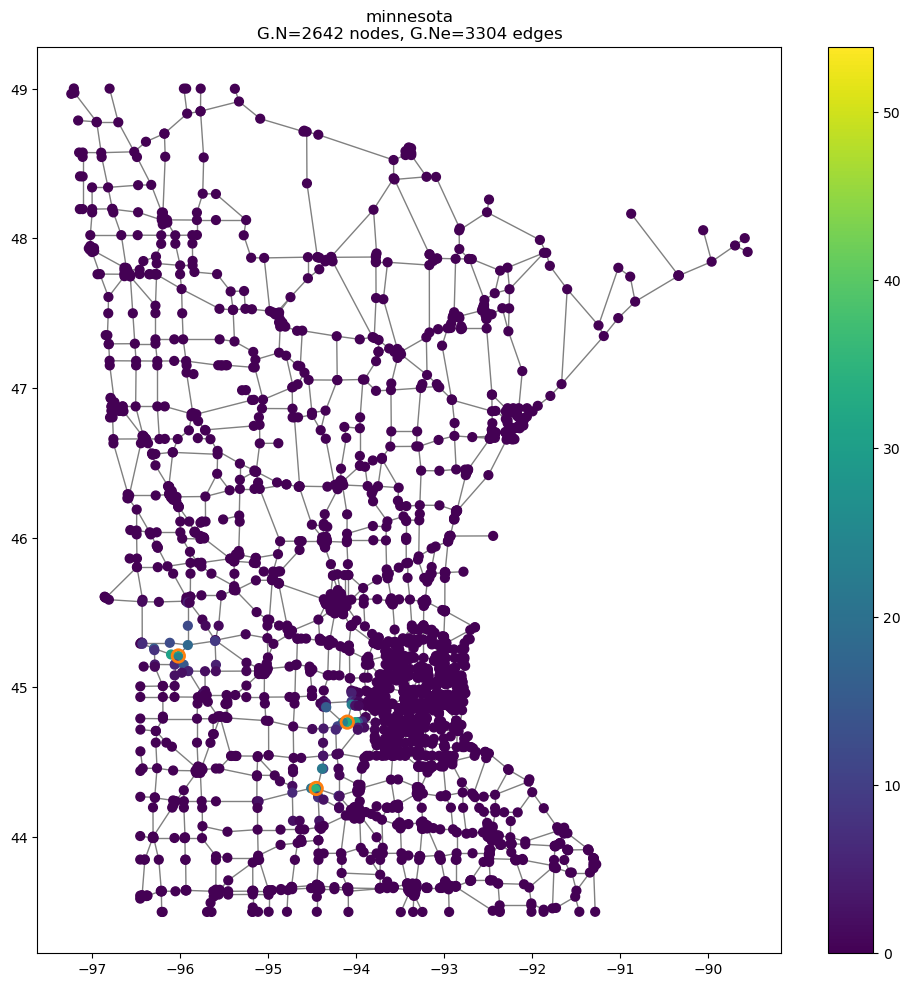

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=100)


g_road.plot_signal(
    filters[-1].filter(signals[-1]),
    colorbar=True,
    highlight=np.nonzero(signals[-1])[0],
    ax=ax,
)

plt.show()


In this case, we might not see a big spread after the first filtering, as the random initial points might be badly connected.
Still, we could imagine that the diffusion process happens over multiple steps. Let's see what happens.

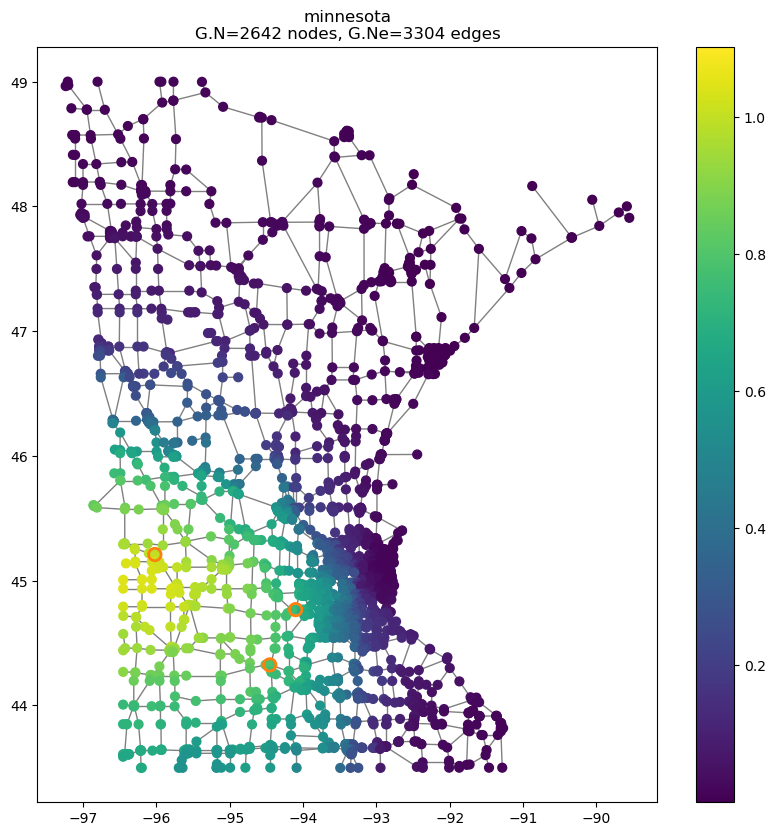

In [28]:
def multi_apply(x, n, f):
    for _ in range(n):
        x = f(x)

    return x


fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

g_road.plot_signal(
    multi_apply(signals[-1], 100, filters[-1].filter),
    colorbar=True,
    highlight=np.nonzero(signals[-1])[0],
    ax=ax,
)


Now the signal is much more distributed! Pay attention to the color scale, though. You will see that the maximum value has significantly decreased from before: our "cars" have been spread out over many nodes.